In [1]:
import os
import functools
import json
import sys
from dataclasses import dataclass
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display
from jaxtyping import Float, Int
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

# Make sure exercises are in the path
chapter = r"chapter0_fundamentals"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part2_cnns"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

import part2_cnns.tests as tests
from part2_cnns.utils import print_param_count
from plotly_utils import line

MAIN = __name__ == "__main__"

device = t.device('mps' if t.backends.mps.is_available() else 'cuda' if t.cuda.is_available() else 'cpu')

In [2]:
class ReLU(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return t.maximum(x, t.tensor(0))


tests.test_relu(ReLU)

All tests in `test_relu` passed!


In [3]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        '''
        A simple linear (technically, affine) transformation.

        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `self.bias` to None.
        '''
        super().__init__()
        
        def kaiming_init(shape, n):
            x = t.rand(shape)
            x = (x * 2) - 1
            return x * (1/(t.sqrt(t.tensor(n))))

        self.weight = nn.Parameter(kaiming_init((out_features, in_features), in_features))
        self.bias = nn.Parameter(kaiming_init((out_features,), in_features)) if bias else None

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (*, in_features)
        Return: shape (*, out_features)
        '''
        x =  einops.einsum(self.weight, x, "out_dim in_dim, ... in_dim -> ... out_dim")
        if self.bias is not None:
            x += self.bias
        return x

    def extra_repr(self) -> str:
        return f"bias={self.bias is not None}"

tests.test_linear_parameters(Linear)
tests.test_linear_parameters(Linear)
tests.test_linear_forward(Linear)
tests.test_linear_forward(Linear)

All tests in `test_linear_parameters` passed!
All tests in `test_linear_parameters` passed!
All tests in `test_linear_forward` passed!
All tests in `test_linear_forward` passed!


In [4]:
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input: t.Tensor) -> t.Tensor:
        '''
        Flatten out dimensions from start_dim to end_dim, inclusive of both.
        '''
        shape = input.shape
        end_dim = self.end_dim if self.end_dim >= 0 else len(shape) + self.end_dim
        left_shape = shape[:self.start_dim]
        mid_shape = functools.reduce(lambda x,y: x * y, shape[self.start_dim: end_dim+1])
        new_shape = shape[:self.start_dim] + (mid_shape,) + shape[end_dim + 1:]
        return t.reshape(input, new_shape)


    def extra_repr(self) -> str:
        pass


tests.test_flatten(Flatten)

All tests in `test_flatten` passed!


In [5]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.linear_1 = Linear(28*28, 100)
        self.relu = ReLU()
        self.linear_2 = Linear(100, 10)

    def forward(self, x: t.Tensor) -> t.Tensor:
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        return x


tests.test_mlp(SimpleMLP)
# tests.test_mlp_forward(SimpleMLP)

All tests in `test_mlp` passed!


In [6]:
MNIST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def get_mnist(subset: int = 1):
    '''Returns MNIST training data, sampled by the frequency given in `subset`.'''
    mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=MNIST_TRANSFORM)
    mnist_testset = datasets.MNIST(root="./data", train=False, download=True, transform=MNIST_TRANSFORM)

    if subset > 1:
        mnist_trainset = Subset(mnist_trainset, indices=range(0, len(mnist_trainset), subset))
        mnist_testset = Subset(mnist_testset, indices=range(0, len(mnist_testset), subset))

    return mnist_trainset, mnist_testset


mnist_trainset, mnist_testset = get_mnist()
mnist_trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=64, shuffle=False)

In [7]:
model = SimpleMLP().to(device)

batch_size = 64
epochs = 3

mnist_trainset, _ = get_mnist(subset = 10)
mnist_trainloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

optimizer = t.optim.Adam(model.parameters(), lr=1e-3)
loss_list = []

for epoch in tqdm(range(epochs)):
    for imgs, labels in mnist_trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss.item())   

line(
    loss_list,
    yaxis_range=[0, max(loss_list) + 0.1],
    x=t.linspace(0, epochs, len(loss_list)),
    labels={"x": "Num epochs", "y": "Cross entropy loss"},
    title="SimpleMLP training on MNIST",
    width=700,
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
@dataclass
class SimpleMLPTrainingArgs():
    '''
    Defining this class implicitly creates an __init__ method, which sets arguments as 
    given below, e.g. self.batch_size = 64. Any of these arguments can also be overridden
    when you create an instance, e.g. args = SimpleMLPTrainingArgs(batch_size=128).
    '''
    batch_size: int = 64
    epochs: int = 3
    learning_rate: float = 1e-3
    subset: int = 10


def train(args: SimpleMLPTrainingArgs):
    '''
    Trains the model, using training parameters from the `args` object.
    '''
    model = SimpleMLP().to(device)

    mnist_trainset, mnist_testset = get_mnist(subset=args.subset)
    mnist_trainloader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
    mnist_testloader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=False)

    optimizer = t.optim.Adam(model.parameters(), lr=args.learning_rate)
    loss_list = []
    accuracy_list = []

    for epoch in tqdm(range(args.epochs)):
        for imgs, labels in mnist_trainloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_list.append(loss.item())   
        
        # Compute validation accuracy on each epoch
        num_test_examples = 0
        correct_examples = 0
        for imgs, labels in mnist_testloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            with t.inference_mode():
                logits = model(imgs)
            classes = logits.argmax(dim=-1)
            correct_examples += (classes == labels).sum().item()
        accuracy_list.append((correct_examples / len(mnist_testset)))


    line(
        loss_list,
        yaxis_range=[0, max(loss_list) + 0.1],
        x=t.linspace(0, args.epochs, len(loss_list)),
        labels={"x": "Num epochs", "y": "Cross entropy loss"},
        title="SimpleMLP training on MNIST",
        width=700,
    )

    line(
        accuracy_list,
        yaxis_range=[0, max(accuracy_list) + 0.1],
        x=t.linspace(0, args.epochs, len(accuracy_list)),
        labels={"x": "Num epochs", "y": "Accuracy"},
        title="SimpleMLP validation accuracy on MNIST",
        width=700,
    )

args = SimpleMLPTrainingArgs(epochs=5)
train(args)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
a = t.tensor([[1,2,3],[4,5,6]])
(a != a).to(float)

tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [10]:
class Conv2d(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0
    ):
        '''
        Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.
        '''
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        
        def xavier_uniform_init(shape):
            x = t.rand(shape)
            x = (x * 2) - 1
            k = 1 / (in_channels * kernel_size**2)
            return x * t.sqrt(t.tensor(k)) 

        weight_shape = (out_channels, in_channels, kernel_size, kernel_size)

        self.weight = nn.Parameter(xavier_uniform_init(weight_shape))
        

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Apply the functional conv2d, which you can import.'''
        x = F.conv2d(input=x, weight=self.weight, stride=self.stride, padding=self.padding)
        return x

    def extra_repr(self) -> str:
        return f"in_channels={self.in_channels},out_channels={self.out_channels},kernel_size={self.kernel_size},stride={self.stride},padding={self.padding}"


tests.test_conv2d_module(Conv2d)
m = Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=2, padding=1)
print(f"Manually verify that this is an informative repr: {m}")

All tests in `test_conv2d_module` passed!
Manually verify that this is an informative repr: Conv2d(in_channels=24,out_channels=12,kernel_size=3,stride=2,padding=1)


In [11]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size: int, stride: int | None = None, padding: int = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding


    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Call the functional version of max_pool2d.'''
        return F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

    def extra_repr(self) -> str:
        '''Add additional information to the string representation of this class.'''
        return f"kernel_size={self.kernel_size},stride={self.stride},padding={self.padding}" 


tests.test_maxpool2d_module(MaxPool2d)
m = MaxPool2d(kernel_size=3, stride=2, padding=1)
print(f"Manually verify that this is an informative repr: {m}")

All tests in `test_maxpool2d_module` passed!
Manually verify that this is an informative repr: MaxPool2d(kernel_size=3,stride=2,padding=1)


# ResNets

In [37]:
class Sequential(nn.Module):
    _modules: dict[str, nn.Module]

    def __init__(self, *modules: nn.Module):
        super().__init__()
        for index, mod in enumerate(modules):
            self._modules[str(index)] = mod

    def __getitem__(self, index: int) -> nn.Module:
        index %= len(self._modules) # deal with negative indices
        return self._modules[str(index)]

    def __setitem__(self, index: int, module: nn.Module) -> None:
        index %= len(self._modules) # deal with negative indices
        self._modules[str(index)] = module

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''Chain each module together, with the output from one feeding into the next one.'''
        for mod in self._modules.values():
            x = mod(x)
        return x

In [83]:
class BatchNorm2d(nn.Module):
    # The type hints below aren't functional, they're just for documentation
    running_mean: Float[Tensor, "num_features"]
    running_var: Float[Tensor, "num_features"]
    num_batches_tracked: Int[Tensor, ""] # This is how we denote a scalar tensor

    def __init__(self, num_features: int, eps=1e-05, momentum=0.1):
        '''
        Like nn.BatchNorm2d with track_running_stats=True and affine=True.

        Name the learnable affine parameters `weight` and `bias` in that order.
        '''
        super().__init__()
        self.weight = nn.Parameter(t.ones(num_features))
        self.bias = nn.Parameter(t.zeros(num_features))

        self.register_buffer("running_mean", t.zeros(num_features))
        self.register_buffer("running_var", t.ones(num_features))
        self.register_buffer("num_batches_tracked", t.zeros(()))

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        Normalize each channel.

        Compute the variance using `torch.var(x, unbiased=False)`
        Hint: you may also find it helpful to use the argument `keepdim`.

        x: shape (batch, channels, height, width)
        Return: shape (batch, channels, height, width)
        '''
        batch, channels, height, width = x.shape

        if self.training:
            # Compute mean and variance over batches and dimensions.
            mean = x.mean(dim=(0,2,3))
            var = x.var(dim=(0,2,3), unbiased=False)
            unbiased_var = x.var(dim=(0,2,3), unbiased=True)

            # Save mean and variance
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * unbiased_var
            self.num_batches_tracked += 1
        else:
            mean = self.running_mean
            var = self.running_var

        # Repeat the mean and variance to match the input size. We don't match the batch size as its done by pytorch broadcasting.
        mean = einops.repeat(mean, "c -> c h w", h=height, w=width)        
        var = einops.repeat(var, "c -> c h w", h=height, w=width)        
        weight = einops.repeat(self.weight, "c -> c h w", h=height, w=width)        
        bias = einops.repeat(self.bias, "c -> c h w", h=height, w=width)        

        x = x - mean
        denominator = t.sqrt(var + self.eps)
        x = x / denominator

        x = t.mul(x, weight)
        x = x + bias
        return x

    def extra_repr(self) -> str:
        # SOLUTION
        return ", ".join([f"{key}={getattr(self, key)}" for key in ["num_features", "eps", "momentum"]])


tests.test_batchnorm2d_module(BatchNorm2d)
tests.test_batchnorm2d_forward(BatchNorm2d)
tests.test_batchnorm2d_running_mean(BatchNorm2d)

All tests in `test_batchnorm2d_module` passed!
All tests in `test_batchnorm2d_forward` passed!
All tests in `test_batchnorm2d_running_mean` passed!


In [84]:
class AveragePool(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels)
        '''
        return einops.reduce(x, "b c h w -> b c", reduction="mean")

In [85]:
class ResidualBlock(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, first_stride=1):
        '''
        A single residual block with optional downsampling.

        For compatibility with the pretrained model, declare the left side branch first using a `Sequential`.

        If first_stride is > 1, this means the optional (conv + bn) should be present on the right branch. Declare it second using another `Sequential`.
        '''
        super().__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.first_stride = first_stride

        self.relu = ReLU()

        self.left_branch = Sequential(
            Conv2d(in_channels=in_feats, out_channels=out_feats, kernel_size=3, stride=first_stride, padding=1),
            BatchNorm2d(num_features=out_feats),
            ReLU(),
            Conv2d(in_channels=out_feats, out_channels=out_feats, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(num_features=out_feats),
        )

        if first_stride == 1:
            self.right_branch = nn.Identity()
        else:
            self.right_branch = Sequential(
                Conv2d(in_channels=in_feats, out_channels=out_feats, kernel_size=1, stride=first_stride, padding=0),
                BatchNorm2d(num_features=out_feats),
            )

    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / stride, width / stride)

        If no downsampling block is present, the addition should just add the left branch's output to the input.
        '''

        left = self.left_branch(x)
        right = self.right_branch(x)

        return self.relu(left + right)

In [86]:
class BlockGroup(nn.Module):
    def __init__(self, n_blocks: int, in_feats: int, out_feats: int, first_stride=1):
        '''An n_blocks-long sequence of ResidualBlock where only the first block uses the provided stride.'''
        super().__init__()
        blocks = [
            ResidualBlock(in_feats=in_feats, out_feats=out_feats, first_stride=first_stride)
        ]
        for i in range(1, n_blocks):
            blocks.append(ResidualBlock(in_feats=out_feats, out_feats=out_feats))
        
        self.blocks = Sequential(*blocks)


    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        '''
        return self.blocks(x)

In [87]:
class ResNet34(nn.Module):
    def __init__(
        self,
        n_blocks_per_group=[3, 4, 6, 3],
        out_features_per_group=[64, 128, 256, 512],
        first_strides_per_group=[1, 2, 2, 2],
        n_classes=1000,
    ):

        super().__init__()
        # n_groups = len(n_blocks_per_group)

        self.conv = Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn = BatchNorm2d(num_features=64)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size=3, stride=2)
        in_features_per_group = [64] + out_features_per_group[:-1]
        block_groups = [
            BlockGroup(n_blocks=n_blocks, in_feats=in_feats, out_feats=out_feats, first_stride=first_stride)
            for n_blocks, in_feats, out_feats, first_stride in zip(n_blocks_per_group, in_features_per_group, out_features_per_group, first_strides_per_group)
        ]
        self.block_groups = Sequential(*block_groups)
        self.avg_pool = AveragePool()
        self.linear = Linear(in_features=out_features_per_group[-1], out_features=1000)


    def forward(self, x: t.Tensor) -> t.Tensor:
        '''
        x: shape (batch, channels, height, width)
        Return: shape (batch, n_classes)
        '''

        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.block_groups(x)
        x = self.avg_pool(x)
        x = self.linear(x)
        return x


my_resnet = ResNet34()

In [88]:
def copy_weights(my_resnet: ResNet34, pretrained_resnet: models.resnet.ResNet) -> ResNet34:
    '''Copy over the weights of `pretrained_resnet` to your resnet.'''

    # Get the state dictionaries for each model, check they have the same number of parameters & buffers
    mydict = my_resnet.state_dict()
    pretraineddict = pretrained_resnet.state_dict()
    assert len(mydict) == len(pretraineddict), "Mismatching state dictionaries."

    # Define a dictionary mapping the names of your parameters / buffers to their values in the pretrained model
    state_dict_to_load = {
        mykey: pretrainedvalue
        for (mykey, myvalue), (pretrainedkey, pretrainedvalue) in zip(mydict.items(), pretraineddict.items())
    }

    # Load in this dictionary to your model
    my_resnet.load_state_dict(state_dict_to_load)

    return my_resnet


pretrained_resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
my_resnet = copy_weights(my_resnet, pretrained_resnet)

In [89]:
print_param_count(my_resnet, pretrained_resnet)

Model 1, total params = 21797672
Model 2, total params = 21797672
All parameter counts match!


Matplotlib is building the font cache; this may take a moment.


,name_1,shape_1,num_params_1,num_params_2,shape_2,name_2
0,conv.weight,"(64, 3, 7, 7)",9408,9408,"(64, 3, 7, 7)",conv1.weight
1,bn.weight,"(64,)",64,64,"(64,)",bn1.weight
2,bn.bias,"(64,)",64,64,"(64,)",bn1.bias
3,block_groups.0.blocks.0.left_branch.0.weight,"(64, 64, 3, 3)",36864,36864,"(64, 64, 3, 3)",layer1.0.conv1.weight
4,block_groups.0.blocks.0.left_branch.1.weight,"(64,)",64,64,"(64,)",layer1.0.bn1.weight
5,block_groups.0.blocks.0.left_branch.1.bias,"(64,)",64,64,"(64,)",layer1.0.bn1.bias
6,block_groups.0.blocks.0.left_branch.3.weight,"(64, 64, 3, 3)",36864,36864,"(64, 64, 3, 3)",layer1.0.conv2.weight
7,block_groups.0.blocks.0.left_branch.4.weight,"(64,)",64,64,"(64,)",layer1.0.bn2.weight
8,block_groups.0.blocks.0.left_branch.4.bias,"(64,)",64,64,"(64,)",layer1.0.bn2.bias
9,block_groups.0.blocks.1.left_branch.0.weight,"(64, 64, 3, 3)",36864,36864,"(64, 64, 3, 3)",layer1.1.conv1.weight


In [90]:
IMAGE_FILENAMES = [
    "chimpanzee.jpg",
    "golden_retriever.jpg",
    "platypus.jpg",
    "frogs.jpg",
    "fireworks.jpg",
    "astronaut.jpg",
    "iguana.jpg",
    "volcano.jpg",
    "goofy.jpg",
    "dragonfly.jpg",
]

IMAGE_FOLDER = section_dir / "resnet_inputs"

images = [Image.open(IMAGE_FOLDER / filename) for filename in IMAGE_FILENAMES]

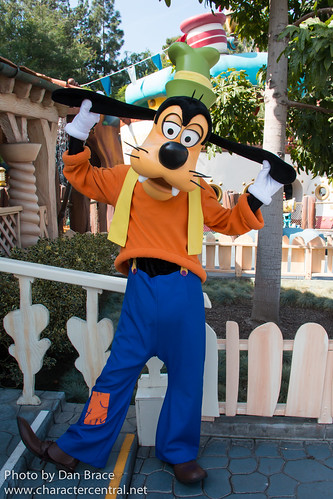

In [94]:
images[8]